<a href="https://colab.research.google.com/github/viktoruebelhart/studies/blob/main/Agent_AI_Trader_simple_agent_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U --quiet langgraph langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.0 MB/s eta 0:00:00


In [ ]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("FINANCIAL_DATASETS_API_KEY")   # For getting financial data. Get from https://financialdatasets.ai
_set_if_undefined("OPENAI_API_KEY")   # For getting financial data. Get from https://financialdatasets.ai

Please provide your FINANCIAL_DATASETS_API_KEY··········
Please provide your OPENAI_API_KEY··········


In [ ]:
# Manipulação de dados
import pandas as pd

# Requisições HTTP
import requests  # Requests: para fazer requisições HTTP, como acessar APIs.

# Funcionalidades do sistema operacional
import os  # OS: para interagir com o sistema operacional (manipular arquivos, diretórios, etc.).

# Expressões regulares
import re  # RE: para manipular e validar padrões em textos usando expressões regulares.

# Manipulação de data e hora
from datetime import datetime, timedelta  # datetime: para trabalhar com datas e horas.

# Visualização de dados
import matplotlib.pyplot as plt  # Matplotlib: para criar gráficos e visualizações de dados.

# Tipagem e tipos anotados
from typing import TypedDict, Annotated, Sequence  # Para definir tipos específicos e garantir maior clareza no código.

# Operações matemáticas e lógicas
import operator  # Para operações matemáticas e lógicas (exemplo: comparação de valores).

# Dependências do agente
from langchain_openai.chat_models import ChatOpenAI  # ChatOpenAI: para usar o modelo de linguagem da OpenAI no agente.
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage  # Para manipular mensagens no agente.

# Grafo de estado
# StateGraph: para construir fluxos de trabalho de agentes e lidar com estados de mensagens.
from langgraph.graph import StateGraph, MessagesState

# 1. Create the Agent

- Inicializa o modelo gpt-4o.
- Define o comportamento do agente no system_prompt.
- Configura o fluxo de mensagens via grafo de estados.
- Função run_agent permite interagir diretamente com o agente para obter uma decisão ("buy", "sell" ou "hold") baseada nos dados históricos fornecidos.

In [ ]:
# Initialize the OpenAI model
gpt_4o_model = ChatOpenAI(model="gpt-4o", temperature=0)

# Define the system prompt
system_prompt = """
You are a financial trading agent.
Based on the provided historical stock price data, make a trading decision for today.
Your decision should be one of:
- 'buy'
- 'sell'
- 'hold'
Only output the decision, without any additional text.
"""

# Define the function that calls the model
def call_agent(state: MessagesState):
    prompt = SystemMessage(content=system_prompt)
    # Get the messages
    messages = state["messages"]

    # Check if the first message is the prompt
    if messages and messages[0].content != system_prompt:
        # Add the prompt to the start of the messages
        messages.insert(0, prompt)

    # Invoke the model and return the response
    return {"messages": [gpt_4o_model.invoke(messages)]}

# Define the agent graph
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_agent)
workflow.set_entry_point("agent")
app = workflow.compile()

# Run the agent
def run_agent(content: str):
    final_state = app.invoke(
        {"messages": [HumanMessage(content=content)]},
        config={"configurable": {"thread_id": 42}}
    )
    return final_state["messages"][-1].content



In [ ]:
run_agent("hello")

'I am here to assist you with trading decisions. Please provide the historical stock price data for analysis.'

# 2. Get Price Data

- A função get_price_data acessa uma API financeira para buscar dados históricos de preços de um ativo entre duas datas específicas, processa esses dados, e retorna um DataFrame com as informações organizadas e tratadas para análise.

In [ ]:
def get_price_data(ticker, start_date, end_date):
    # Add your API key to the headers
    headers = {
        "X-API-KEY": os.environ.get("FINANCIAL_DATASETS_API_KEY")
    }

    # Create the URL
    url = (
        f'https://api.financialdatasets.ai/prices/'
        f'?ticker={ticker}'
        f'&interval=day'
        f'&interval_multiplier=1'
        f'&start_date={start_date}'
        f'&end_date={end_date}'
    )

    # Make API request
    response = requests.get(url, headers=headers)

    # Check for successful response
    if response.status_code != 200:
        raise Exception(f"Error fetching data: {response.status_code} - {response.text}")

    # Parse prices from the response
    data = response.json()
    prices = data.get('prices')
    if not prices:
        raise ValueError("No price data returned")

    # Convert prices to DataFrame
    df = pd.DataFrame(prices)

    # Convert 'time' to datetime and set as index
    df['Date'] = pd.to_datetime(df['time'])
    df.set_index('Date', inplace=True)

    # Ensure numeric data types
    numeric_cols = ['open', 'close', 'high', 'low', 'volume']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Sort by date
    df.sort_index(inplace=True)

    return df


# 3. Create a backtester

## O que é o código?

O código é para testar como um "agente de IA" tomaria decisões de compra e venda de ativos (como ações) no mercado financeiro, usando dados históricos de preços. O **Backtester** (teste retrospectivo) simula as negociações que o agente faria se estivesse investindo no passado, e depois avalia o desempenho dessas decisões.

---

## Explicação do código passo a passo:

### 1. A Classe Backtester
A classe **Backtester** é como se fosse uma máquina de testar, onde você coloca as informações do agente, as ações que ele deve tomar e as condições de investimento. Ela simula as compras e vendas com base no histórico de preços para ver se as decisões do agente são boas.

### 2. A Função `__init__` (Construtor)
Esta função inicializa o backtester, ou seja, define os parâmetros principais, como:

- **Agente de IA**: Quem vai tomar as decisões (ex: se comprar, vender ou segurar ações).
- **Ticker**: O ativo (por exemplo, a ação de uma empresa) que o agente vai negociar.
- **Data de Início e Fim**: O período de tempo durante o qual o backtester vai simular as negociações.
- **Capital Inicial**: O quanto de dinheiro o agente tem no começo para começar a comprar e vender ativos.

### 3. Função `load_data`
A função `load_data` busca os dados históricos dos preços do ativo (como as ações) entre as datas definidas. Ela também garante que esses dados estejam organizados por data (do mais antigo para o mais recente).

### 4. Função `initialize_portfolio`
Aqui, o portfólio do agente é inicializado. Ele começa com o dinheiro inicial e nenhuma ação (ou seja, ele não tem ações compradas ainda). O valor do portfólio é o valor total que o agente tem (dinheiro em caixa + valor das ações).

### 5. Função `parse_action`
Quando o agente de IA toma uma decisão, ele responde com uma palavra: 'buy' (comprar), 'sell' (vender), ou 'hold' (segurar). Essa função pega a resposta do agente e a interpreta para saber se o agente quer comprar, vender ou segurar.

### 6. Função `execute_trade`
Essa função executa as ações de compra ou venda. Se o agente decidir comprar, ele usa o dinheiro disponível para comprar o maior número possível de ações. Se ele decidir vender, ele vende todas as ações que ele tem e recebe o dinheiro.

- **Comprar**: Ele verifica se tem dinheiro suficiente para comprar o máximo possível de ações com o dinheiro disponível.
- **Vender**: Ele verifica se tem ações para vender e, caso tenha, vende todas.

### 7. Função `run_backtest`
A função `run_backtest` é o coração do código. Ela faz o seguinte:

1. Simula as negociações do agente dia a dia.
2. A cada dia, a IA recebe os preços históricos dos últimos 5 dias e decide se vai comprar, vender ou segurar.
3. Dependendo da decisão do agente, a função executa a ação de compra ou venda.
4. Depois de cada negociação, a função calcula o valor total do portfólio (dinheiro em caixa + valor das ações) e registra essa informação.
5. O código imprime as ações do agente, o preço do ativo e o valor do portfólio a cada dia.

### 8. Função `analyze_performance`
Após simular todas as negociações, essa função analisa como o portfólio se comportou ao longo do tempo:

- **Total Return** (Retorno Total): Mostra quanto o portfólio cresceu ou diminuiu em relação ao valor inicial.
- **Gráfico de Valor do Portfólio**: Mostra como o valor do portfólio mudou ao longo do tempo, para ver se o agente estava fazendo bons investimentos.
- **Sharpe Ratio**: Mede o risco ajustado. Quanto mais alto, melhor, pois significa que o agente estava obtendo um bom retorno em relação ao risco.
- **Máxima Queda (Maximum Drawdown)**: Mostra qual foi a maior perda do portfólio em algum momento. Isso é útil para ver quão arriscada foi a estratégia do agente.

---

## Resumo Final
O código simula um agente de IA comprando e vendendo ações com base em dados históricos.
Ele registra como o valor do portfólio (o total de dinheiro + ações) muda com o tempo.
No final, o código analisa o desempenho do agente, mostrando o retorno total, o risco e a maior perda que o agente sofreu.


## Fluxograma

https://www.mermaidchart.com/app/projects/52c09706-022f-4deb-8680-2583790473d5/diagrams/4cf0fff8-96d0-440e-94ff-245126a7fb34/version/v0.1/edit


In [ ]:
class Backtester:
    def __init__(self, agent, ticker, start_date, end_date, initial_capital):
        self.agent = agent
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.initial_capital = initial_capital
        self.data = None
        self.portfolio = None
        self.portfolio_values = []

    def load_data(self):
        self.data = get_price_data(self.ticker, self.start_date, self.end_date)
        # Ensure data is sorted by date
        self.data.sort_index(inplace=True)

    def initialize_portfolio(self):
        self.portfolio = {
            'cash': self.initial_capital,
            'stock': 0,
            'portfolio_value': self.initial_capital
        }

    def parse_action(self, agent_output):
        # Use regular expressions to find 'buy', 'sell', or 'hold' in the agent's output
        match = re.search(r'\b(buy|sell|hold)\b', agent_output.lower())
        if match:
            return match.group(1)
        else:
            # If no valid action is found, default to 'hold'
            return 'hold'

    def execute_trade(self, action, current_price):
        if action == 'buy' and self.portfolio['cash'] >= current_price:
            # Buy as many shares as possible with available cash
            shares_to_buy = int(self.portfolio['cash'] // current_price)
            self.portfolio['stock'] += shares_to_buy
            self.portfolio['cash'] -= shares_to_buy * current_price
        elif action == 'sell' and self.portfolio['stock'] > 0:
            # Sell all shares
            self.portfolio['cash'] += self.portfolio['stock'] * current_price
            self.portfolio['stock'] = 0
        # else 'hold' or not enough cash/stock to trade

    def run_backtest(self):
        window_size = 5  # Number of days of historical data to provide to the agent
        data = self.data

        # Ensure there are enough data points
        if len(data) < window_size:
            raise ValueError("Not enough data to perform backtest.")

        print("\nStarting backtest...")
        print(f"{'Date':<12} {'Action':<6} {'Price':>8} {'Shares':>8} {'Cash':>12} {'Total Value':>12}")
        print("-" * 60)

        for idx in range(window_size, len(data)):
            current_date = data.index[idx]
            # Get historical data up to the current date
            historical_data = data.iloc[idx - window_size:idx]
            historical_prices = historical_data['close'].tolist()
            price_history_str = ', '.join([f"{price:.2f}" for price in historical_prices])

            content = f"""
            Here is the closing price data for the last {window_size} days: {price_history_str}.

            Based on this data, what is your trading decision for today? Please respond with only one word: 'buy', 'sell', or 'hold'.
            """

            # Agent makes a decision
            agent_output = self.agent(content)
            action = self.parse_action(agent_output)
            current_price = data.loc[current_date, 'close']

            # Execute the agent's action
            self.execute_trade(action, current_price)

            # Update total portfolio value
            total_value = self.portfolio['cash'] + self.portfolio['stock'] * current_price
            self.portfolio['portfolio_value'] = total_value

            # Log the current state
            print(f"{current_date.strftime('%Y-%m-%d'):<12} {action:<6} {current_price:>8.2f} {self.portfolio['stock']:>8d} {self.portfolio['cash']:>12.2f} {total_value:>12.2f}")

            # Record the portfolio value
            self.portfolio_values.append({
                'Date': current_date,
                'Portfolio Value': total_value
            })

    def analyze_performance(self):
        # Convert portfolio values to DataFrame
        performance_df = pd.DataFrame(self.portfolio_values).set_index('Date')

        # Calculate total return
        total_return = (self.portfolio['portfolio_value'] - self.initial_capital) / self.initial_capital
        print(f"Total Return: {total_return * 100:.2f}%")

        # Plot the portfolio value over time
        performance_df['Portfolio Value'].plot(title='Portfolio Value Over Time', figsize=(12,6))
        plt.ylabel('Portfolio Value ($)')
        plt.xlabel('Date')
        plt.show()

        # Compute daily returns
        performance_df['Daily Return'] = performance_df['Portfolio Value'].pct_change()

        # Calculate Sharpe Ratio (assuming 252 trading days in a year)
        mean_daily_return = performance_df['Daily Return'].mean()
        std_daily_return = performance_df['Daily Return'].std()
        sharpe_ratio = (mean_daily_return / std_daily_return) * (252 ** 0.5)
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

        # Calculate Maximum Drawdown
        rolling_max = performance_df['Portfolio Value'].cummax()
        drawdown = performance_df['Portfolio Value'] / rolling_max - 1
        max_drawdown = drawdown.min()
        print(f"Maximum Drawdown: {max_drawdown * 100:.2f}%")

        return performance_df

# 4. Run the Backtest

##### Backtest é uma simulação que testa uma estratégia de investimento usando dados passados, para ver como ela teria se saído se tivesse sido aplicada no passado

- Este trecho de código configura e executa o backtest de um agente de IA negociando as ações da Apple (AAPL) entre 1º de junho de 2024 e 21 de novembro de 2024, com $100.000 de capital inicial. O backtest simula as negociações, registra o desempenho do agente e fornece uma análise final do retorno e riscos do portfólio


Starting backtest...
Date         Action    Price   Shares         Cash  Total Value
------------------------------------------------------------
2024-06-10   buy      193.12      517       156.96    100000.00
2024-06-11   hold     207.15      517       156.96    107253.51
2024-06-12   sell     213.07        0    110314.15    110314.15
2024-06-13   buy      214.24      514       194.79    110314.15
2024-06-14   sell     212.49        0    109414.65    109414.65
2024-06-17   sell     216.67        0    109414.65    109414.65
2024-06-18   buy      214.29      510       126.75    109414.65
2024-06-20   hold     209.68      510       126.75    107063.55
2024-06-21   sell     207.49        0    105946.65    105946.65
2024-06-24   sell     208.14        0    105946.65    105946.65
2024-06-25   hold     209.07        0    105946.65    105946.65
2024-06-26   hold     213.25        0    105946.65    105946.65
2024-06-27   buy      214.10      494       181.25    105946.65
2024-06-28   buy     

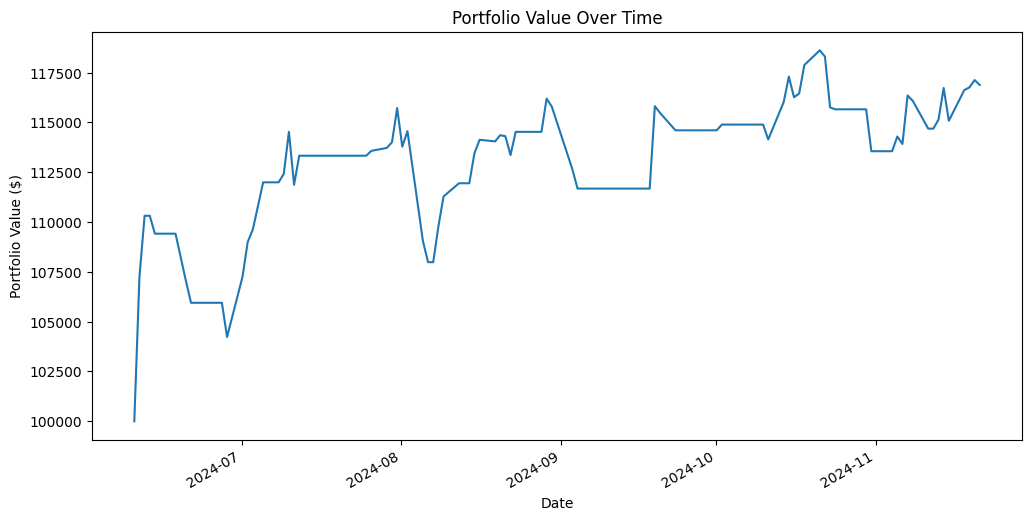

Sharpe Ratio: 1.79
Maximum Drawdown: -6.69%


In [ ]:
# Define parameters
ticker = 'AAPL'  # Example ticker symbol
start_date = '2024-06-01'  # Adjust as needed
end_date = '2024-11-21'    # Adjust as needed
initial_capital = 100000  # $100,000

# Create an instance of Backtester
backtester = Backtester(
    agent=run_agent,
    ticker=ticker,
    start_date=start_date,
    end_date=end_date,
    initial_capital=initial_capital
)

# Run the backtesting process
backtester.load_data()
backtester.initialize_portfolio()
backtester.run_backtest()
performance_df = backtester.analyze_performance()